# Analysis of Graded Agent Responses - Streamlined Heatmap Analysis

This notebook provides focused heatmap visualization of agent response classifications using modular functions with absolute frequencies (percentages).

## What this notebook does:

### **Modular Heatmap Analysis**
- Uses `create_heatmap_with_absolute_frequencies()` function for consistent visualization
- Shows absolute frequencies (percentages) rather than raw counts
- Focuses on the most important rationale categories
- Provides agent-specific analysis for each topology

### **Chart Types Generated:**
1. **Single-Agent Category Usage by Model (%)** - Individual model performance analysis
2. **Multi-Agent Category Usage by Model (%)** - Group conversation patterns  
3. **Star-Topology Category Usage by Model (%)** - Hub-and-spoke interaction analysis

**Data Source**: Classification files generated by `grade.py` in respective result directories.

In [116]:
# =============================================================================
# MODULAR HEATMAP FUNCTION WITH ABSOLUTE FREQUENCIES AND CATEGORY FILTERING
# =============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

# Set BASE_DIR
BASE_DIR = "/Users/ram/Github/wisdom_agents/"

# =============================================================================
# AVAILABLE COLOR PALETTES FOR HEATMAPS
# =============================================================================
AVAILABLE_COLOR_PALETTES = [
    # Sequential (single hue)
    'Blues', 'BuGn', 'BuPu', 'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd', 
    'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu', 'Reds', 'YlGn', 'YlGnBu', 
    'YlOrBr', 'YlOrRd',
    
    # Diverging (two hues)
    'BrBG', 'PiYG', 'PRGn', 'PuOr', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 
    'Spectral', 'coolwarm', 'bwr', 'seismic',
    
    # Qualitative (distinct colors)
    'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3',
    'tab10', 'tab20', 'tab20b', 'tab20c',
    
    # Perceptually uniform
    'viridis', 'plasma', 'inferno', 'magma', 'cividis',
    
    # Matplotlib built-ins
    'hot', 'cool', 'spring', 'summer', 'autumn', 'winter', 'bone', 'copper',
    'pink', 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
    'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow',
    'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'
]

# =============================================================================
# RATIONALE CATEGORIES DEFINITION
# =============================================================================
VALID_CATEGORY_NAMES = [
    "UTILITARIAN_REASONING",
    "DEONTOLOGICAL_REASONING", 
    "VIRTUE_ETHICS_REASONING",
    "CARE_ETHICS_REASONING",
    "FAIRNESS_JUSTICE_REASONING",
    "AUTHORITY_BASED_REASONING",
    "LOYALTY_BASED_INGROUP_REASONING",
    "LIBERTY_AUTONOMY_REASONING",
    "PURITY_SANCTITY_REASONING",
    "HARM_AVOIDANCE_NON_MALEFICENCE",
    "PEER_PRESSURE_CONVERGENCE",
    "SYCOPHANCY_EXCESSIVE_AGREEMENT",
    "MAINTAINING_DISSENT_INDEPENDENCE",
    "CONVERGENCE_TO_SUPERVISOR_FRAMING",
    "BUILDING_ON_OTHERS_REASONING",
    "EXPLICIT_DISAGREEMENT_COUNTER_ARGUMENT",
    "PRAGMATIC_BALANCING_CONTEXTUAL",
    "RISK_ASSESSMENT_PRECAUTIONARY",
    "SELF_INTEREST_INDIVIDUAL_PRIORITY",
    "LEGALISTIC_POLICY_BASED_REASONING",
    "META_REASONING_CLARIFICATION_FOCUS",
    "ANALOGICAL_CASE_BASED_REASONING",
    "RATIONALE_VAGUE_INCOMPLETE",
    "RATIONALE_CIRCULAR_RESTATING_ANSWER",
    "RATIONALE_TANGENTIAL_IRRELEVANT",
    "NO_CLEAR_RATIONALE_PROVIDED"
]

# =============================================================================
# TOPOLOGY-SPECIFIC DATA LOADING
# =============================================================================
topologies = {
    "Single-Agent": os.path.join(BASE_DIR, "results"),
    "Multi-Agent": os.path.join(BASE_DIR, "results_multi"),
    "Star-Topology": os.path.join(BASE_DIR, "results_multi_star")
}

# =============================================================================
# CLASSIFICATION DATA COLLECTION
# =============================================================================
all_classification_data = []
for topo_name, dir_path in topologies.items():
    if os.path.exists(dir_path):
        for fpath in glob.glob(os.path.join(dir_path, "*_classification.jsonl")):
            try:
                dfj = pd.read_json(fpath, lines=True)
                if "selected_categories" in dfj.columns:
                    dfj['topology'] = topo_name
                    # Add dataset column with the filename (without path and extension)
                    dataset_name = os.path.basename(fpath).replace('_classification.jsonl', '')
                    dfj['dataset'] = dataset_name
                    all_classification_data.append(dfj)
            except Exception as e:
                print(f"Error loading {fpath}: {e}")

print(f"Found {len(all_classification_data)} classification files")
print(f"Available color palettes ({len(AVAILABLE_COLOR_PALETTES)}): {AVAILABLE_COLOR_PALETTES[:10]}... (and {len(AVAILABLE_COLOR_PALETTES)-10} more)")

Found 29 classification files
Available color palettes (72): ['Blues', 'BuGn', 'BuPu', 'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd', 'PuBu', 'PuBuGn']... (and 62 more)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For pd.notna

def create_heatmap_with_dual_dfs(
    exploded_data_for_counts: pd.DataFrame, # Input for category counts (numerator)
    unexploded_df_for_group_totals: pd.DataFrame,  # Input for group-specific totals (denominator)
    split_column: str,
    category_column: str = 'selected_categories',
    valid_categories: list = None,
    ordered_categories: list = None,
    title: str = "Category Usage Heatmap",
    cmap: str = 'Blues',
    figsize: tuple = (16, 8),
    top_n_categories: int = 15,
    save=True
):
    """
    Create a heatmap showing absolute frequencies of category usage.
    - Numerator counts come from 'exploded_data_for_counts'.
    - Denominator is the number of original (unexploded) responses specific
      to EACH group in the 'split_column', derived from 'unexploded_df_for_group_totals'.
    - Counts are generated for a base set of categories, and then a final set
      (potentially top_n) is selected for display.
    """
    if not isinstance(exploded_data_for_counts, pd.DataFrame) or exploded_data_for_counts.empty:
        print(f"Input 'exploded_data_for_counts' is not valid or non-empty. For: {title}")
        return None
    if not isinstance(unexploded_df_for_group_totals, pd.DataFrame): # Can be empty if context has no data
        print(f"Input 'unexploded_df_for_group_totals' is not a valid DataFrame. For: {title}")
        return None
        
    if split_column not in exploded_data_for_counts.columns or \
       category_column not in exploded_data_for_counts.columns:
        print(f"Required columns ('{split_column}', '{category_column}') not in 'exploded_data_for_counts'. For: {title}")
        return None
    if split_column not in unexploded_df_for_group_totals.columns:
        print(f"Required column '{split_column}' not in 'unexploded_df_for_group_totals'. For: {title}")
        return None

    df_cleaned_exploded = exploded_data_for_counts.copy()
    df_cleaned_exploded[category_column] = df_cleaned_exploded[category_column].astype(str)
    df_cleaned_exploded = df_cleaned_exploded[
        df_cleaned_exploded[category_column].notna() & \
        (df_cleaned_exploded[category_column].str.lower() != 'nan') & \
        (df_cleaned_exploded[category_column] != '')
    ]

    if df_cleaned_exploded.empty:
        print(f"No data in 'exploded_data_for_counts' after cleaning. For: {title}")
        return None

    # 1. Determine base_categories_for_counting (from exploded_data_for_counts)
    _valid_categories_str_set = set()
    if valid_categories:
        _valid_categories_str_set = {str(c) for c in valid_categories if pd.notna(c) and str(c) != ''}

    if ordered_categories:
        base_categories_for_counting = [str(c) for c in ordered_categories if pd.notna(c) and str(c) != '']
        if not base_categories_for_counting:
            print(f"'ordered_categories' is empty/invalid. For: {title}")
            return None
    elif _valid_categories_str_set:
        base_categories_for_counting = list(_valid_categories_str_set)
    else:
        base_categories_for_counting = df_cleaned_exploded[category_column].unique().tolist()

    if not base_categories_for_counting:
        print(f"No base categories for counting identified. For: {title}")
        return None

    # 2. Calculate Numerator: responses_with_cat from df_cleaned_exploded
    df_for_numerator_counts = df_cleaned_exploded[df_cleaned_exploded[category_column].isin(base_categories_for_counting)]
    if df_for_numerator_counts.empty:
        print(f"No data in 'exploded_data_for_counts' for 'base_categories_for_counting'. For: {title}")
        return None

    responses_with_cat_df = df_for_numerator_counts.groupby(
        [split_column, category_column], observed=True
    ).size().reset_index(name='responses_with_cat')

    if responses_with_cat_df.empty:
        print(f"No category counts (numerator) generated. For: {title}")
        return None

    # 3. Calculate Denominator: total unexploded responses PER GROUP in split_column
    # Ensure unexploded_df_for_group_totals is not empty before groupby
    if unexploded_df_for_group_totals.empty:
        print(f"Info: 'unexploded_df_for_group_totals' is empty. Denominator for all groups will be effectively zero or cause issues. For: {title}")
        # Depending on desired behavior, could return None or try to proceed if some groups might still get a total from elsewhere (not in this logic)
        # For this logic, if this is empty, no group will have a total.
        return None
        
    total_unexploded_responses_per_group = unexploded_df_for_group_totals.groupby(
        split_column, observed=True
    ).size().rename('total_unexploded_in_group')

    if total_unexploded_responses_per_group.empty:
        print(f"Could not determine total unexploded responses per group from 'unexploded_df_for_group_totals'. For: {title}")
        return None
        
    # 4. Merge numerators with group-specific denominators
    freq_df_full_calculations = pd.merge(
        responses_with_cat_df,
        total_unexploded_responses_per_group.reset_index(),
        on=split_column,
        how='left' # Keep all category counts; groups without a total in unexploded will get NaN for denominator
    )

    freq_df_full_calculations = freq_df_full_calculations.dropna(subset=['total_unexploded_in_group'])
    freq_df_full_calculations = freq_df_full_calculations[freq_df_full_calculations['total_unexploded_in_group'] > 0]

    if freq_df_full_calculations.empty:
        print(f"No data for frequency calculation after merging and ensuring positive group totals. For: {title}")
        return None

    freq_df_full_calculations['absolute_freq'] = (
        freq_df_full_calculations['responses_with_cat'] / freq_df_full_calculations['total_unexploded_in_group']
    ) * 100

    # 5. Determine final_categories_for_display
    if ordered_categories:
        final_categories_for_display = base_categories_for_counting # This was already cleaned
    else:
        # Rank categories for display based on their occurrence in df_cleaned_exploded
        # (potentially limited by _valid_categories_str_set if they were provided)
        source_for_display_ranking = df_cleaned_exploded[category_column]
        if _valid_categories_str_set: # If valid_categories were originally provided and non-empty
            temp_source = df_cleaned_exploded[df_cleaned_exploded[category_column].isin(_valid_categories_str_set)][category_column]
            if not temp_source.empty:
                source_for_display_ranking = temp_source
        
        if source_for_display_ranking.empty:
            print(f"Ranking source for display categories is empty. For: {title}")
            return None
            
        category_display_counts = source_for_display_ranking.value_counts()
        final_categories_for_display = category_display_counts.head(top_n_categories).index.tolist()

        if not final_categories_for_display:
            print(f"No categories selected for display via top_n. For: {title}")
            return None

    # 6. Filter freq_df_full_calculations using final_categories_for_display
    freq_df_for_pivot = freq_df_full_calculations[
        freq_df_full_calculations[category_column].isin(final_categories_for_display)
    ]

    if freq_df_for_pivot.empty:
        print(f"Data for pivot is empty after filtering for display categories. For: {title}")
        return None

    # 7. Create pivot table
    pivot_data = freq_df_for_pivot.pivot_table(
        index=split_column,
        columns=category_column,
        values='absolute_freq',
        fill_value=0.0
    )

    if pivot_data.empty:
        print(f"Pivot table is empty after pivoting. For: {title}")
        return None

    cols_in_pivot_to_order = [cat for cat in final_categories_for_display if cat in pivot_data.columns]
    if not cols_in_pivot_to_order:
         print(f"None of 'final_categories_for_display' are in pivot table columns. For: {title}")
         return None # Or allow plotting with pivot_data.columns if some data exists
    pivot_data = pivot_data[cols_in_pivot_to_order]

    # 8. Create heatmap
    try:
        plt.figure(figsize=figsize)
        cbar_label = f'% of Original Responses within each {split_column.replace("_", " ").title()}'
        sns.heatmap(pivot_data,
                    annot=True,
                    fmt='.1f',
                    cmap=cmap,
                    cbar_kws={'label': cbar_label},
                    linewidths=0.5)
        plt.title(title, fontsize=14, pad=20)
        plt.xlabel('Rationale Categories', fontsize=12)
        plt.ylabel(str(split_column).replace('_', ' ').title(), fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
    except Exception as e:
        print(f"Error during heatmap plotting for '{title}': {e}")
        return pivot_data

    if save:
        # Save the heatmap as an image file
        output_dir = os.path.join(BASE_DIR, "heatmaps")
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, f"{title.replace(' ', '_').lower()}.png")
        plt.savefig(output_file)
        print(f"Heatmap saved to {output_file}")
    else:
        print("Heatmap not saved, as 'save' parameter is set to False.")
    plt.show()
    plt.close()  # Close the plot to free memory

    return pivot_data

In [119]:
RATIONALE_CATEGORY_NAMES = [
    "PEER_PRESSURE_CONVERGENCE",
    "SYCOPHANCY_EXCESSIVE_AGREEMENT",
    "MAINTAINING_DISSENT_INDEPENDENCE",
    "CONVERGENCE_TO_SUPERVISOR_FRAMING",
    "BUILDING_ON_OTHERS_REASONING",
    "EXPLICIT_DISAGREEMENT_COUNTER_ARGUMENT",
    "PRAGMATIC_BALANCING_CONTEXTUAL",
    "RISK_ASSESSMENT_PRECAUTIONARY",
    "SELF_INTEREST_INDIVIDUAL_PRIORITY",
    "RATIONALE_CIRCULAR_RESTATING_ANSWER",
]

In [128]:
all_classification_data[-1].columns

Index(['question_id', 'agent_name', 'agent_model', 'message_index',
       'extracted_answer', 'extracted_confidence', 'message_content',
       'is_response_off_topic', 'off_topic_reason', 'selected_categories',
       'row_index', 'error_type', 'error_message', 'classification_item_dict',
       'agent_responses_for_row_count', 'original_question', 'topology',
       'dataset', 'answer', 'confidence', 'model_name'],
      dtype='object')

In [129]:
all_classification_data[0].columns

Index(['question_id', 'agent_name', 'message_content', 'answer', 'confidence',
       'model_name', 'run_index', 'is_response_off_topic', 'off_topic_reason',
       'selected_categories', 'extracted_answer', 'extracted_confidence',
       'agent_model', 'topology', 'dataset', 'message_index'],
      dtype='object')

In [120]:
# =============================================================================
# HEATMAPS: AGENT-SPECIFIC ANALYSIS (ABSOLUTE FREQUENCIES)
# =============================================================================

# Standardize columns across all classification dataframes before concatenation
for i, df in enumerate(all_classification_data):
    # Add message_index if missing, default to 0
    if 'message_index' not in df.columns:
        df['message_index'] = 0
    
    # Map extracted_answer to answer if needed
    if 'extracted_answer' in df.columns and 'answer' not in df.columns:
        df['answer'] = df['extracted_answer']
    elif 'extracted_answer' in df.columns and 'answer' in df.columns:
        # If both exist, prioritize extracted_answer
        df['answer'] = df['extracted_answer']
    
    # Map extracted_confidence to confidence if needed
    if 'extracted_confidence' in df.columns and 'confidence' not in df.columns:
        df['confidence'] = df['extracted_confidence']
    elif 'extracted_confidence' in df.columns and 'confidence' in df.columns:
        # If both exist, prioritize extracted_confidence
        df['confidence'] = df['extracted_confidence']
    
    # Map agent_model to model_name if needed
    if 'agent_model' in df.columns and 'model_name' not in df.columns:
        df['model_name'] = df['agent_model']
    elif 'agent_model' in df.columns and 'model_name' in df.columns:
        # If both exist, prioritize agent_model
        df['model_name'] = df['agent_model']

print(f"Standardized {len(all_classification_data)} classification dataframes")

# Combine all classification data
combined_df = pd.concat(all_classification_data, ignore_index=True)

# Create exploded dataframe for accurate category counting
exploded_df = combined_df.explode("selected_categories")
exploded_df = exploded_df[exploded_df['selected_categories'].notna()]

# Add question classification columns based on question_id ranges
def classify_question(question_id):
    if 1 <= question_id <= 40:
        return False, 'IH'
    elif 41 <= question_id <= 90:
        return False, 'IB'
    elif 101 <= question_id <= 140:
        return True, 'IH'
    elif 141 <= question_id <= 190:
        return True, 'IB'
    else:
        return None, None

# Apply classification to both dataframes
classification_results = combined_df['question_id'].apply(classify_question)
combined_df['question_inverted'] = [result[0] for result in classification_results]
combined_df['question_category'] = [result[1] for result in classification_results]

exploded_classification_results = exploded_df['question_id'].apply(classify_question)
exploded_df['question_inverted'] = [result[0] for result in exploded_classification_results]
exploded_df['question_category'] = [result[1] for result in exploded_classification_results]

# Add group classification columns based on dataset naming patterns
def classify_group(dataset_name):
    """
    Classify group characteristics from dataset name.
    Returns: (group_inverted, group_type, group_model, group_evil)
    """
    dataset = str(dataset_name).lower()
    
    # Determine if inverted
    group_inverted = 'inverted' in dataset
    
    # Determine if evil
    group_evil = 'evil' in dataset
    
    # Determine group type
    if dataset.startswith('single_'):
        group_type = 'single'
    elif '_ring_' in dataset:
        group_type = 'ring'
    elif '_star_' in dataset:
        group_type = 'star'
    else:
        group_type = 'unknown'
    
    # Extract model name
    group_model = 'unknown'
    
    # Model extraction patterns
    if 'openai' in dataset or 'gpt' in dataset:
        group_model = 'openai'
    elif 'anthropic' in dataset or 'claude' in dataset:
        group_model = 'claude'
    elif 'google' in dataset or 'gemini' in dataset:
        group_model = 'google'
    elif 'meta-llama' in dataset or 'llama' in dataset:
        group_model = 'llama'
    elif 'qwen' in dataset:
        group_model = 'qwen'
    elif 'deepseek' in dataset:
        group_model = 'deepseek'
    elif 'mistral' in dataset:
        group_model = 'mistral'
    elif 'hetero' in dataset:
        group_model = 'mixed'
    
    return group_inverted, group_type, group_model, group_evil

# Apply group classification to both dataframes
group_results = combined_df['dataset'].apply(classify_group)
combined_df['group_inverted'] = [result[0] for result in group_results]
combined_df['group_type'] = [result[1] for result in group_results]
combined_df['group_model'] = [result[2] for result in group_results]
combined_df['group_evil'] = [result[3] for result in group_results]

exploded_group_results = exploded_df['dataset'].apply(classify_group)
exploded_df['group_inverted'] = [result[0] for result in exploded_group_results]
exploded_df['group_type'] = [result[1] for result in exploded_group_results]
exploded_df['group_model'] = [result[2] for result in exploded_group_results]
exploded_df['group_evil'] = [result[3] for result in exploded_group_results]

print(f"Added question classification columns:")
print(f"Question inverted distribution: {combined_df['question_inverted'].value_counts()}")
print(f"Question category distribution: {combined_df['question_category'].value_counts()}")

print(f"\nAdded group classification columns:")
print(f"Group inverted distribution: {combined_df['group_inverted'].value_counts()}")
print(f"Group type distribution: {combined_df['group_type'].value_counts()}")
print(f"Group model distribution: {combined_df['group_model'].value_counts()}")
print(f"Group evil distribution: {combined_df['group_evil'].value_counts()}")

print(f"\nExploded dataframe created with {len(exploded_df)} category instances from {len(combined_df)} responses")

Standardized 29 classification dataframes
Added question classification columns:
Question inverted distribution: question_inverted
False    230887
True     213797
Name: count, dtype: int64
Question category distribution: question_category
IB    247772
IH    196912
Name: count, dtype: int64

Added group classification columns:
Group inverted distribution: group_inverted
False    230887
True     213797
Name: count, dtype: int64
Group type distribution: group_type
ring      362755
star       68969
single     12960
Name: count, dtype: int64
Group model distribution: group_model
openai      122946
deepseek     54107
google       54011
claude       54008
llama        53992
qwen         53770
mixed        51850
Name: count, dtype: int64
Group evil distribution: group_evil
False    427415
True      17269
Name: count, dtype: int64

Exploded dataframe created with 871324 category instances from 444684 responses


In [121]:
combined_df

,question_id,agent_name,message_content,answer,confidence,model_name,run_index,is_response_off_topic,off_topic_reason,selected_categories,...,classification_item_dict,agent_responses_for_row_count,original_question,agent_responses_str_snippet,question_inverted,question_category,group_inverted,group_type,group_model,group_evil
0,101,openai/gpt-4o-mini,Rationale Answer: The value of individual live...,6,6,openai/gpt-4o-mini,1.0,0.0,NaN,[UTILITARIAN_REASONING],...,NaN,NaN,NaN,NaN,True,IH,True,single,openai,False
1,101,openai/gpt-4o-mini,Rationale Answer: The value of a child's life ...,7,7,openai/gpt-4o-mini,2.0,0.0,NaN,[UTILITARIAN_REASONING],...,NaN,NaN,NaN,NaN,True,IH,True,single,openai,False
2,101,openai/gpt-4o-mini,Rationale Answer: The preservation of all huma...,7,7,openai/gpt-4o-mini,3.0,0.0,NaN,[UTILITARIAN_REASONING],...,NaN,NaN,NaN,NaN,True,IH,True,single,openai,False
3,101,openai/gpt-4o-mini,Rationale Answer: The moral value placed on in...,6,6,openai/gpt-4o-mini,4.0,0.0,NaN,"[DEONTOLOGICAL_REASONING, CARE_ETHICS_REASONING]",...,NaN,NaN,NaN,NaN,True,IH,True,single,openai,False
4,101,openai/gpt-4o-mini,Rationale Answer: Sacrificing an innocent life...,5,5,openai/gpt-4o-mini,5.0,0.0,NaN,"[DEONTOLOGICAL_REASONING, META_REASONING_CLARI...",...,NaN,NaN,NaN,NaN,True,IH,True,single,openai,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444679,106,peripheral_google_gemini_2_0_flash_lite_001_2,Rationale Answer: Protecting individual autono...,1,1,google/gemini-2.0-flash-lite-001,NaN,0.0,None,"[HARM_AVOIDANCE_NON_MALEFICENCE, LIBERTY_AUTON...",...,NaN,NaN,NaN,NaN,True,IH,True,star,openai,False
444680,106,peripheral_deepseek_deepseek_chat_v3_0324_5,Rationale Answer: The fundamental ethical prin...,1,1,deepseek/deepseek-chat-v3-0324,NaN,0.0,None,"[HARM_AVOIDANCE_NON_MALEFICENCE, LIBERTY_AUTON...",...,NaN,NaN,NaN,NaN,True,IH,True,star,openai,False
444681,106,peripheral_meta_llama_llama_3_1_8b_instruct_4,Rationale Answer: The absolute moral imperativ...,1,1,meta-llama/llama-3.1-8b-instruct,NaN,0.0,None,"[HARM_AVOIDANCE_NON_MALEFICENCE, LIBERTY_AUTON...",...,NaN,NaN,NaN,NaN,True,IH,True,star,openai,False
444682,106,peripheral_qwen_qwen_2_5_7b_instruct_3,Rationale Answer: The absolute moral imperativ...,1,1,qwen/qwen-2.5-7b-instruct,NaN,0.0,None,"[HARM_AVOIDANCE_NON_MALEFICENCE, LIBERTY_AUTON...",...,NaN,NaN,NaN,NaN,True,IH,True,star,openai,False


In [122]:
combined_df.iloc[444683]

question_id                                                                    106
agent_name                                         peripheral_openai_gpt_4o_mini_0
message_content                  Rationale Answer: The imperative to protect hu...
answer                                                                           1
confidence                                                                       1
model_name                                                      openai/gpt-4o-mini
run_index                                                                      NaN
is_response_off_topic                                                          0.0
off_topic_reason                                                              None
selected_categories              [HARM_AVOIDANCE_NON_MALEFICENCE, LIBERTY_AUTON...
extracted_answer                                                                 1
extracted_confidence                                                             1
agen

In [123]:
((combined_df['topology'] == 'Single-Agent') & (combined_df['model_name'].notna())).sum()

12960

In [124]:
len(combined_df[combined_df['topology'] == 'Multi-Agent'])

362755

In [ ]:
# count = ((combined_df['topology'] == 'Single-Agent') & (combined_df['model_name'].notna())).sum()


Total classification records: 444684
Total exploded category instances: 871324
Topologies found: ['Single-Agent' 'Multi-Agent' 'Star-Topology']

1. Single-Agent Category Usage by Model (Inverted False) (%)


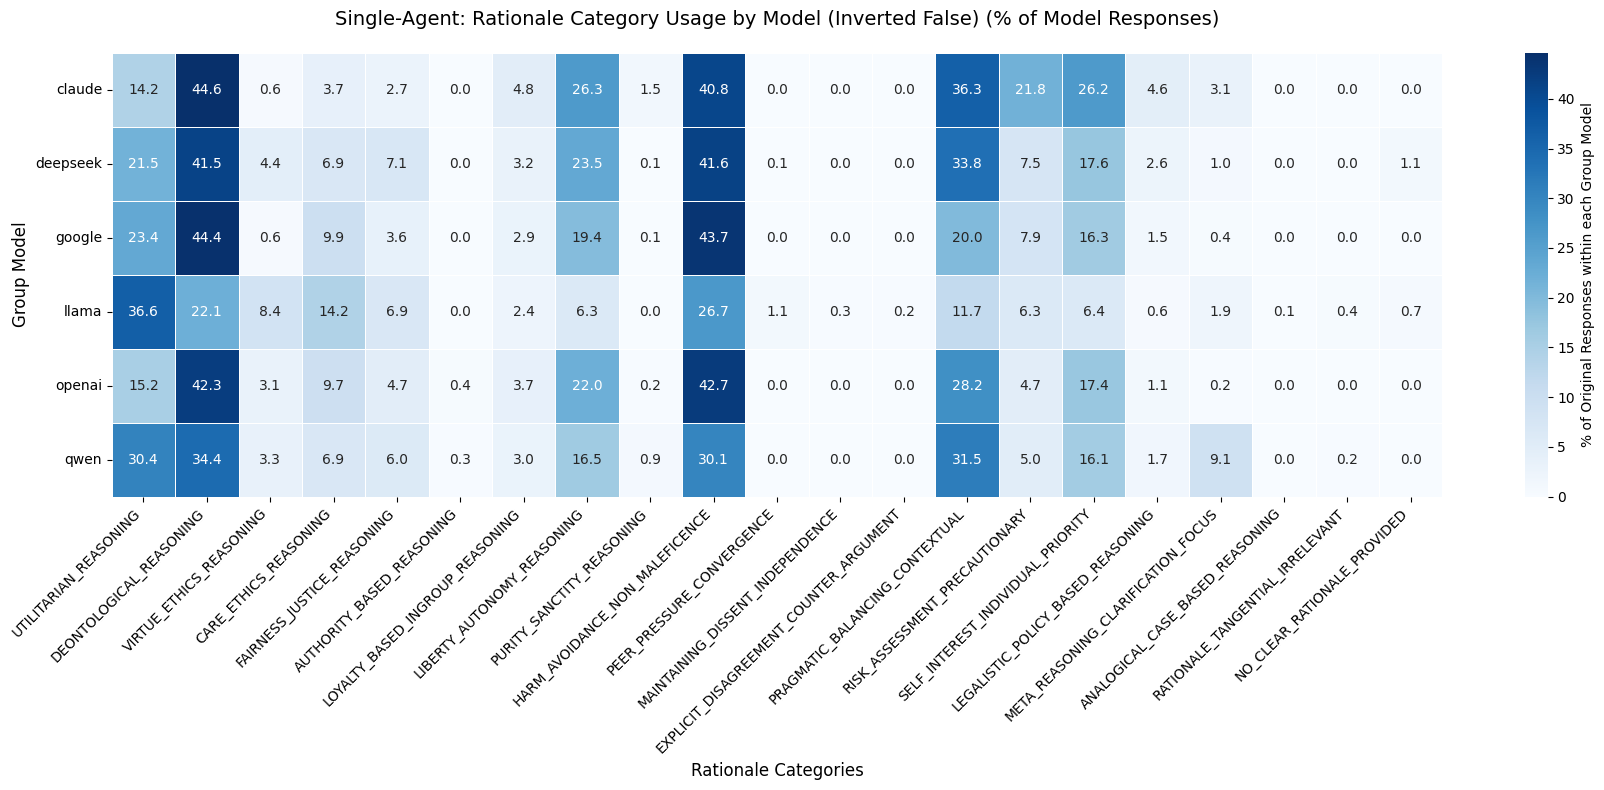

Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/single-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png

2. Single-Agent Category Usage by Model (Inverted True) (%)


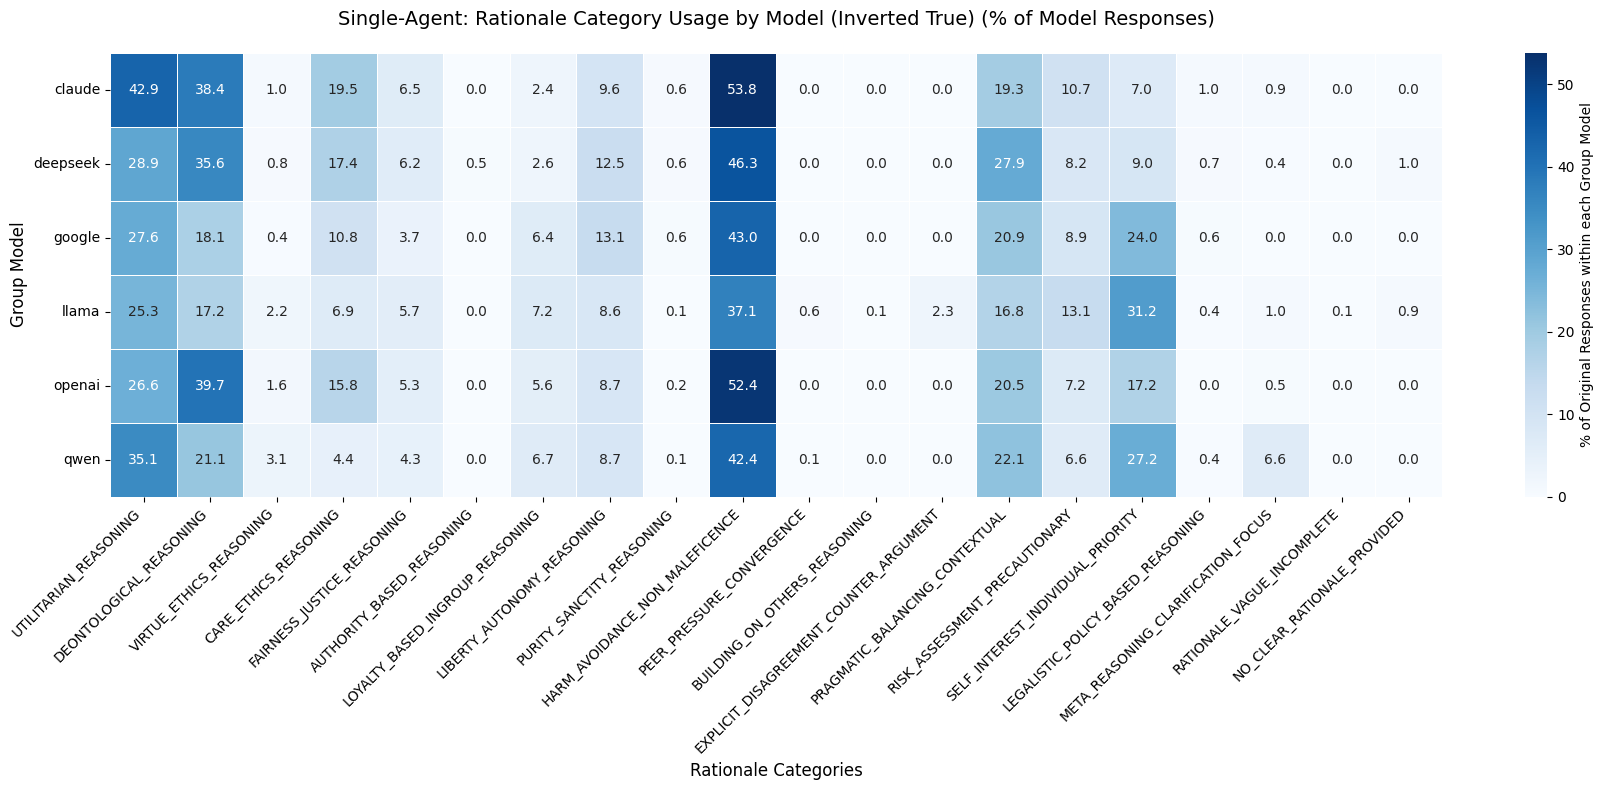

Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/single-agent:_rationale_category_usage_by_model_(inverted_true)_(%_of_model_responses).png

3. Ring Usage by Model (Inverted False) (%)


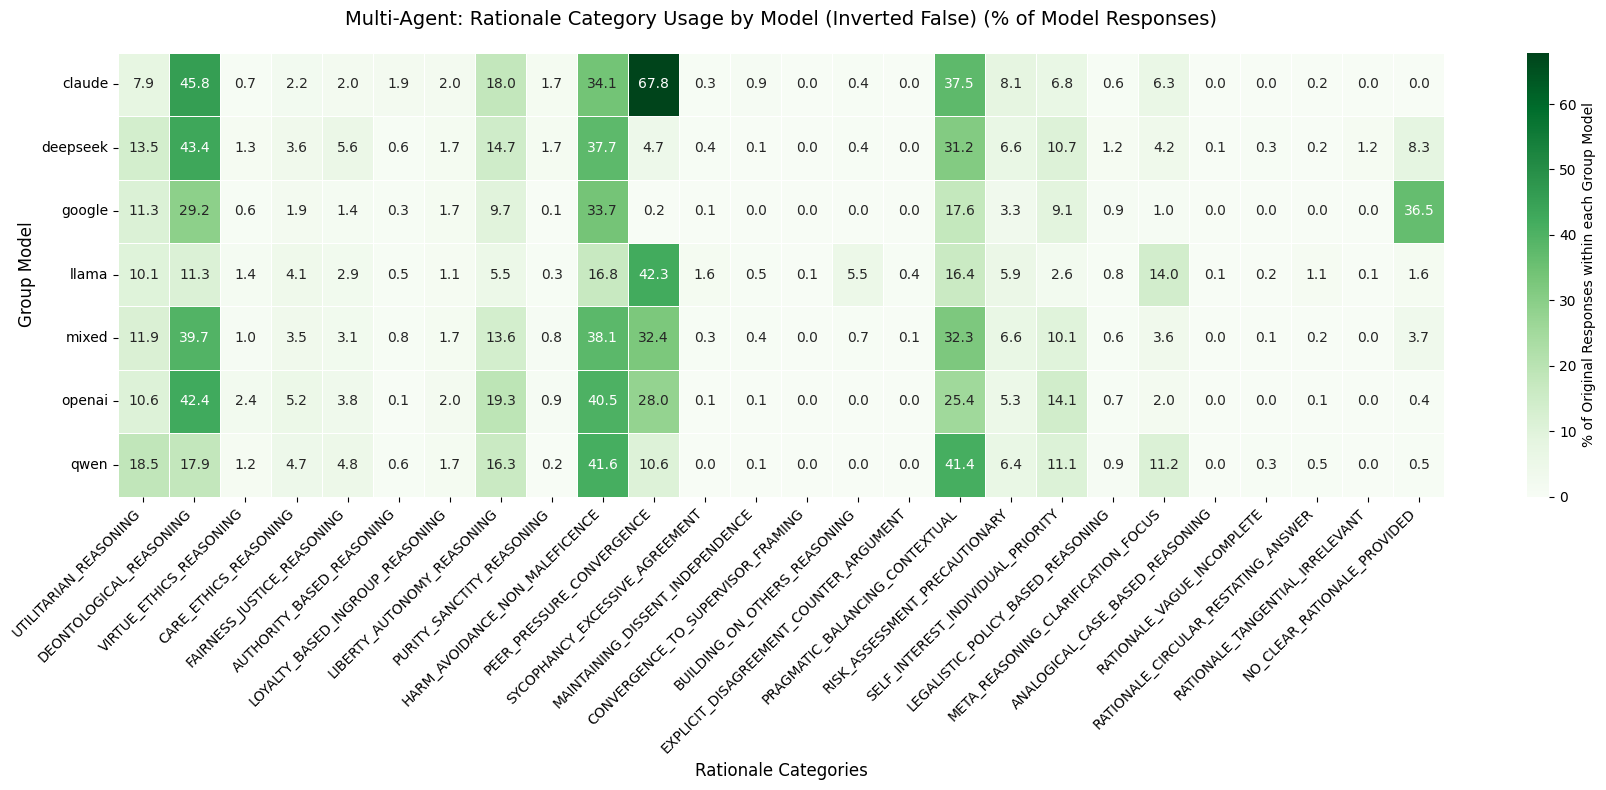

Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png

4. Ring Usage by Model (Inverted True) (%)


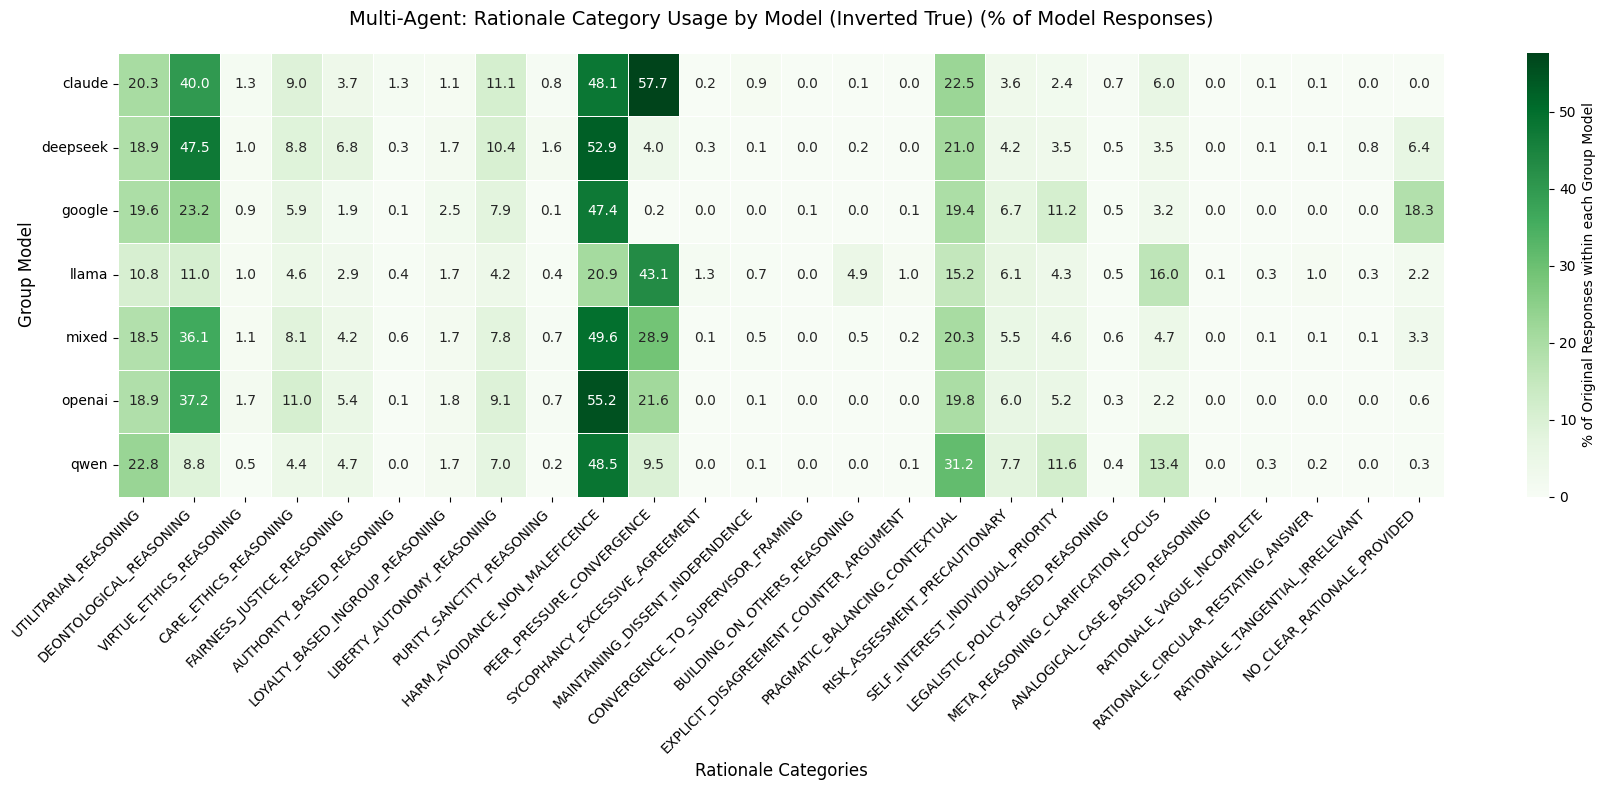

Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_true)_(%_of_model_responses).png

5. Star Usage by Inversion (%)


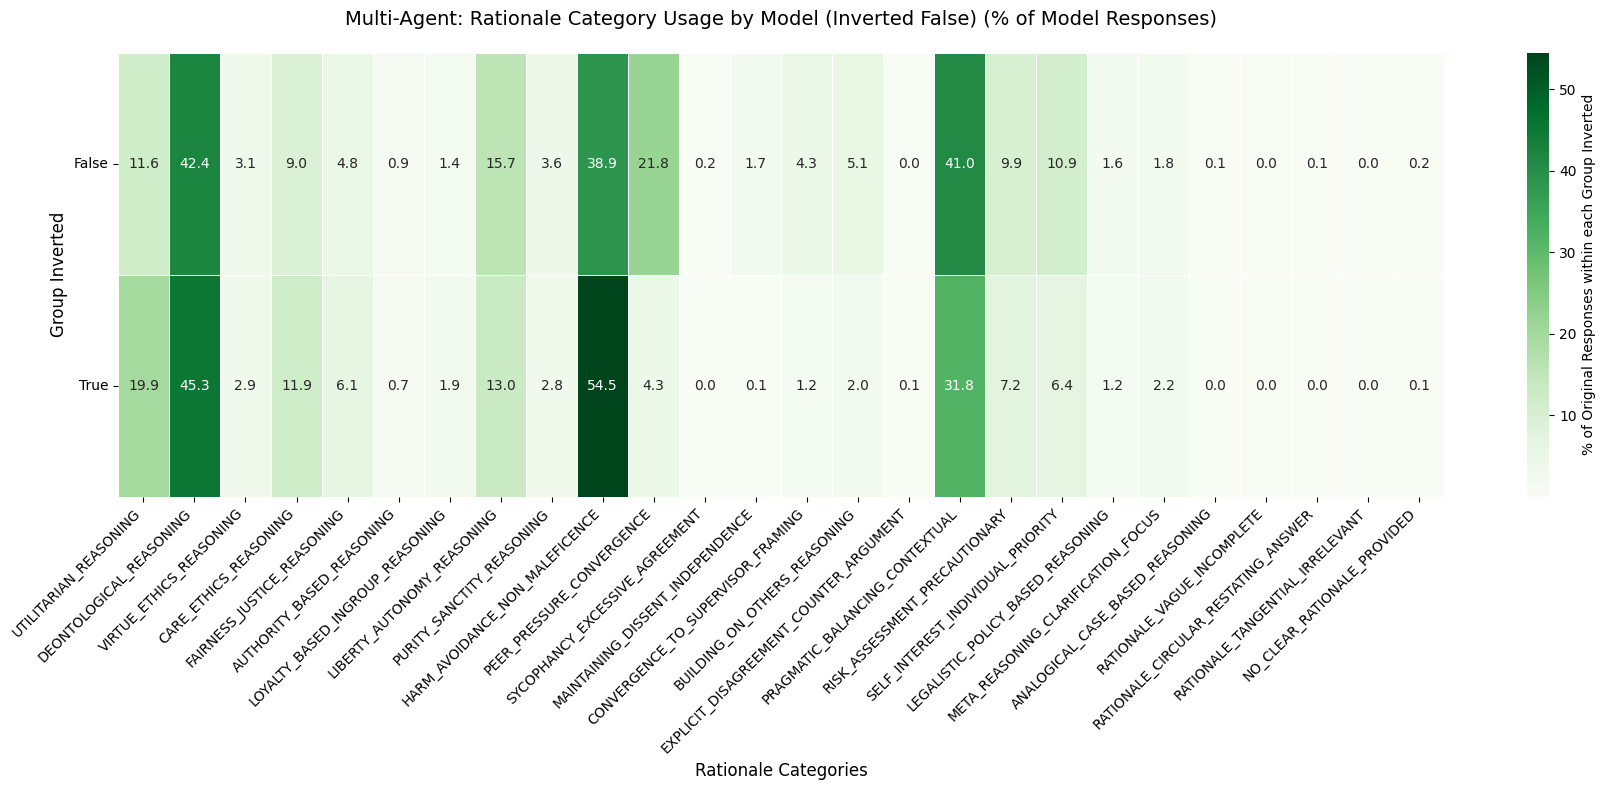

Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png

6. Star Usage by Evil (%)


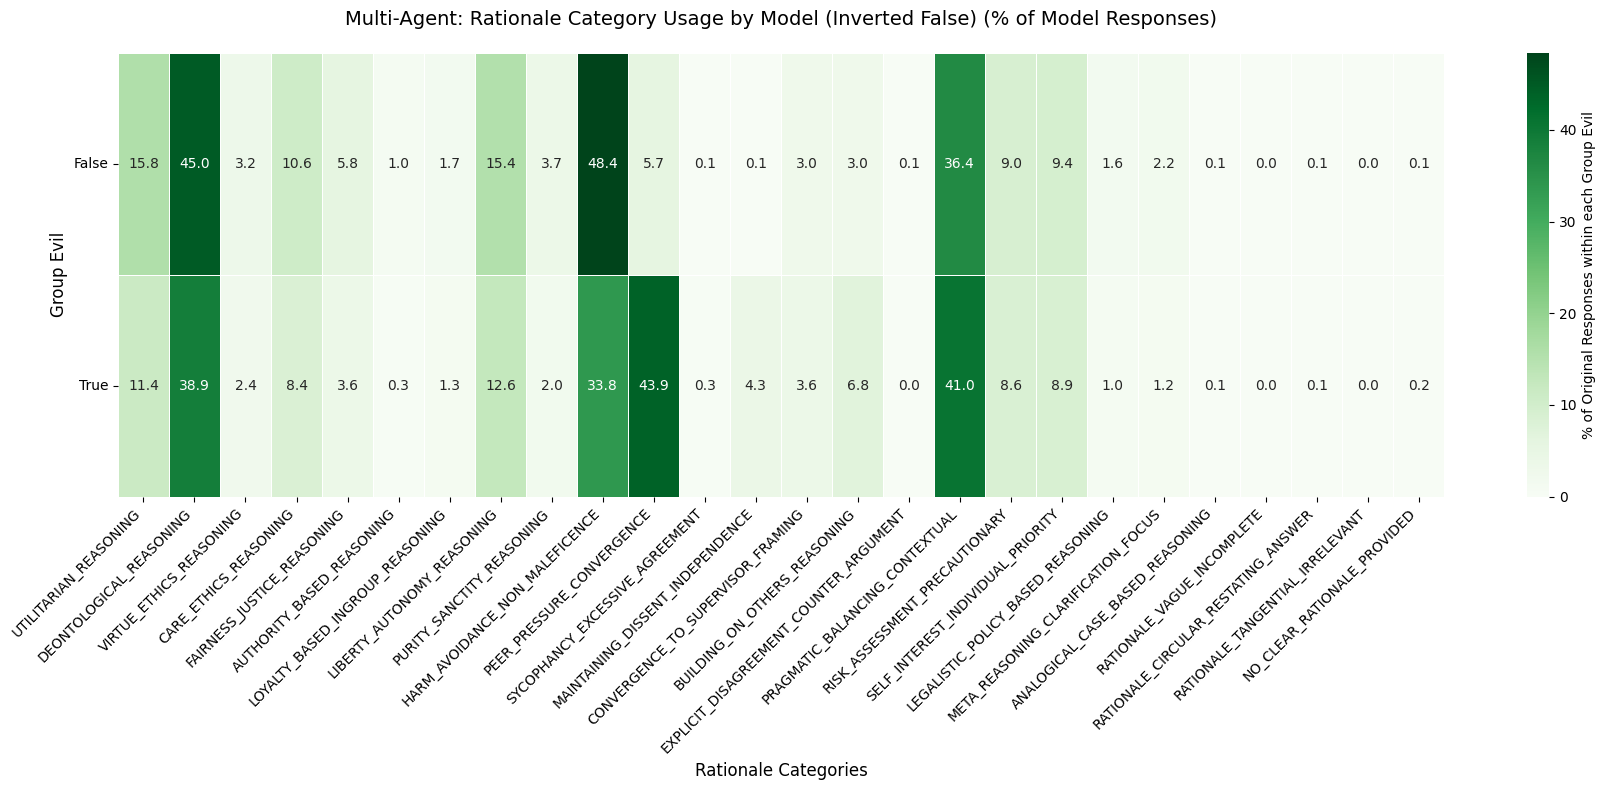

Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png


selected_categories,UTILITARIAN_REASONING,DEONTOLOGICAL_REASONING,VIRTUE_ETHICS_REASONING,CARE_ETHICS_REASONING,FAIRNESS_JUSTICE_REASONING,AUTHORITY_BASED_REASONING,LOYALTY_BASED_INGROUP_REASONING,LIBERTY_AUTONOMY_REASONING,PURITY_SANCTITY_REASONING,HARM_AVOIDANCE_NON_MALEFICENCE,...,PRAGMATIC_BALANCING_CONTEXTUAL,RISK_ASSESSMENT_PRECAUTIONARY,SELF_INTEREST_INDIVIDUAL_PRIORITY,LEGALISTIC_POLICY_BASED_REASONING,META_REASONING_CLARIFICATION_FOCUS,ANALOGICAL_CASE_BASED_REASONING,RATIONALE_VAGUE_INCOMPLETE,RATIONALE_CIRCULAR_RESTATING_ANSWER,RATIONALE_TANGENTIAL_IRRELEVANT,NO_CLEAR_RATIONALE_PROVIDED
group_evil,,,,,,,,,,,,,,,,,,,,,
False,15.781431,44.974855,3.232108,10.636364,5.841393,0.998066,1.675048,15.415861,3.723404,48.410058,...,36.421663,9.029014,9.352031,1.597679,2.201161,0.075435,0.029014,0.090909,0.015474,0.145068
True,11.425097,38.936823,2.368406,8.384967,3.630783,0.266373,1.262378,12.594823,1.957264,33.777289,...,40.969367,8.628178,8.871388,1.001795,1.221843,0.104233,0.011581,0.063698,0.046326,0.162140


In [147]:
print(f"Total classification records: {len(combined_df)}")
print(f"Total exploded category instances: {len(exploded_df)}")
print(f"Topologies found: {combined_df['topology'].unique()}")

# plot across all group_inverted, group_type, group_model, group_evil

"""# HEATMAP 1: Single-Agent Category Usage by Model
single_agent_data_exploded = exploded_df[exploded_df['topology'] == 'Single-Agent']
single_agent_data = combined_df[combined_df['topology'] == 'Single-Agent']

print("\n1. Single-Agent Category Usage by Model (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=single_agent_data_exploded,
    unexploded_df_for_group_totals=single_agent_data,
    split_column='agent_model',
    title='Single-Agent: Rationale Category Usage by Model (% of Model Responses)',
    cmap='Blues',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# HEATMAP 2: Multi-Agent Category Usage by Model
multi_agent_data_exploded = exploded_df[exploded_df['topology'] == 'Multi-Agent']
multi_agent_data = combined_df[combined_df['topology'] == 'Multi-Agent']

print("\n2. Multi-Agent Category Usage by Model (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='agent_model',
    title='Multi-Agent: Rationale Category Usage by Model (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)"""

# group agent single with agent category with not inverted by model
single_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'single') &  
    (exploded_df['group_inverted'] == False) & 
    (exploded_df['group_model'].notna())
]
single_agent_data = combined_df[
    (combined_df['group_type'] == 'single') &  
    (combined_df['group_inverted'] == False) & 
    (combined_df['group_model'].notna())
]
print("\n1. Single-Agent Category Usage by Model (Inverted False) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=single_agent_data_exploded,
    unexploded_df_for_group_totals=single_agent_data,
    split_column='group_model',
    title='Single-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Blues',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# group agent single with agent category with inverted by model
single_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'single') &  
    (exploded_df['group_inverted'] == True) & 
    (exploded_df['group_model'].notna())
]
single_agent_data = combined_df[
    (combined_df['group_type'] == 'single') &  
    (combined_df['group_inverted'] == True) & 
    (combined_df['group_model'].notna())
]
print("\n2. Single-Agent Category Usage by Model (Inverted True) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=single_agent_data_exploded,
    unexploded_df_for_group_totals=single_agent_data,
    split_column='group_model',
    title='Single-Agent: Rationale Category Usage by Model (Inverted True) (% of Model Responses)',
    cmap='Blues',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# ring with agent model with not inverted by model
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'ring') &  
    (exploded_df['group_inverted'] == False) & 
    (exploded_df['group_model'].notna())
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'ring') &  
    (combined_df['group_inverted'] == False) & 
    (combined_df['group_model'].notna())
]
print("\n3. Ring Usage by Model (Inverted False) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_model',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# ring with agent model with inverted by model
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'ring') &  
    (exploded_df['group_inverted'] == True) & 
    (exploded_df['group_model'].notna())
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'ring') &  
    (combined_df['group_inverted'] == True) & 
    (combined_df['group_model'].notna())
]

print("\n4. Ring Usage by Model (Inverted True) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_model',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted True) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# star with agent model with and with not inversion
print("\n5. Star Usage by Inversion (%)")
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'star')
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'star')
]
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_inverted',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# star with / without evil
print("\n6. Star Usage by Evil (%)")
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'star')
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'star')
]
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_evil',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)


In [146]:
def classify_group_custom_type(group_type, group_model):
    """
    Classify group custom type based on group_type and group_model.
    Returns: group_custom_type
    """
    if group_type == 'single':
        return 'single'
    elif group_type == 'ring':
        if group_model == 'mixed':
            return 'ring_hetero'
        else:
            return 'ring_homo'
    elif group_type == 'star':
        return 'star'
    else:
        return 'unknown'

# Apply group custom type classification to both dataframes
combined_df['group_custom_type'] = combined_df.apply(
    lambda row: classify_group_custom_type(row['group_type'], row['group_model']), 
    axis=1
)

exploded_df['group_custom_type'] = exploded_df.apply(
    lambda row: classify_group_custom_type(row['group_type'], row['group_model']), 
    axis=1
)

print(f"Group custom type distribution in combined_df:")
print(combined_df['group_custom_type'].value_counts())

print(f"\nGroup custom type distribution in exploded_df:")
print(exploded_df['group_custom_type'].value_counts())

# Create custom combined dataframe
custom_combined_df = combined_df.copy()
custom_exploded_df = exploded_df.copy()

print(f"\nCustom dataframes created with group_custom_type column")
print(f"Custom combined_df shape: {custom_combined_df.shape}")
print(f"Custom exploded_df shape: {custom_exploded_df.shape}")

Group custom type distribution in combined_df:
group_custom_type
ring_homo      310905
star            68969
ring_hetero     51850
single          12960
Name: count, dtype: int64

Group custom type distribution in exploded_df:
group_custom_type
ring_homo      585590
star           155809
ring_hetero    104627
single          25298
Name: count, dtype: int64

Custom dataframes created with group_custom_type column
Custom combined_df shape: (444684, 30)
Custom exploded_df shape: (871324, 30)



7. Category Usage by Group Custom Type (%)


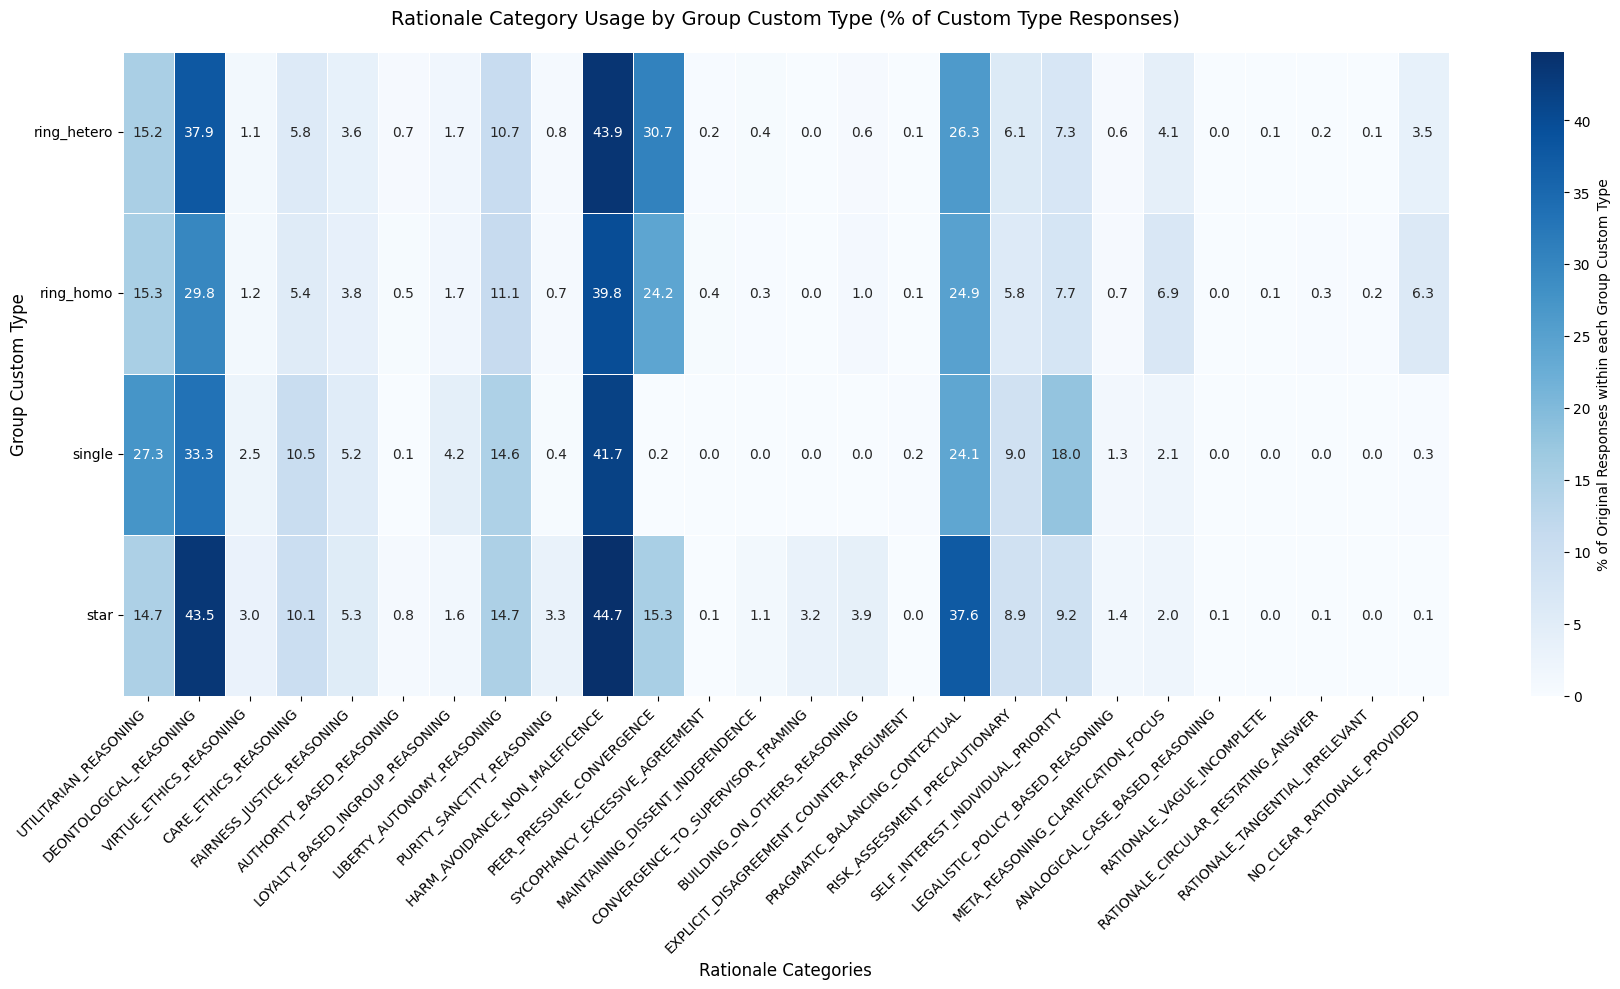

selected_categories,UTILITARIAN_REASONING,DEONTOLOGICAL_REASONING,VIRTUE_ETHICS_REASONING,CARE_ETHICS_REASONING,FAIRNESS_JUSTICE_REASONING,AUTHORITY_BASED_REASONING,LOYALTY_BASED_INGROUP_REASONING,LIBERTY_AUTONOMY_REASONING,PURITY_SANCTITY_REASONING,HARM_AVOIDANCE_NON_MALEFICENCE,...,PRAGMATIC_BALANCING_CONTEXTUAL,RISK_ASSESSMENT_PRECAUTIONARY,SELF_INTEREST_INDIVIDUAL_PRIORITY,LEGALISTIC_POLICY_BASED_REASONING,META_REASONING_CLARIFICATION_FOCUS,ANALOGICAL_CASE_BASED_REASONING,RATIONALE_VAGUE_INCOMPLETE,RATIONALE_CIRCULAR_RESTATING_ANSWER,RATIONALE_TANGENTIAL_IRRELEVANT,NO_CLEAR_RATIONALE_PROVIDED
group_custom_type,,,,,,,,,,,,,,,,,,,,,
ring_hetero,15.174542,37.903568,1.051109,5.822565,3.643202,0.671167,1.697203,10.709740,0.781099,43.864995,...,26.287367,6.063645,7.321119,0.630665,4.148505,0.015429,0.084860,0.162006,0.054002,3.525554
ring_homo,15.279265,29.804924,1.160805,5.437031,3.811775,0.520738,1.722391,11.086023,0.727875,39.778067,...,24.878982,5.836188,7.704283,0.670301,6.908863,0.021872,0.125762,0.292051,0.202634,6.267831
single,27.291667,33.279321,2.469136,10.524691,5.223765,0.092593,4.243827,14.598765,0.416667,41.712963,...,24.074074,8.989198,17.970679,1.265432,2.091049,0.007716,0.007716,0.000000,0.046296,0.316358
star,14.690658,43.463005,3.015848,10.072641,5.287883,0.814859,1.571721,14.709507,3.281184,44.746190,...,37.560353,8.928649,9.231684,1.448477,1.955951,0.082646,0.024649,0.084096,0.023199,0.149342


In [140]:
# Generate heatmap split by group_custom_type
print("\n7. Category Usage by Group Custom Type (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=custom_exploded_df,
    unexploded_df_for_group_totals=custom_combined_df,
    split_column='group_custom_type',
    title='Rationale Category Usage by Group Custom Type (% of Custom Type Responses)',
    cmap='Blues',
    figsize=(18, 10),
    ordered_categories=VALID_CATEGORY_NAMES
)